In [1]:
import random
random.seed(42)

In [2]:
import numpy as np 
import pandas as pd 
 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold 
from sklearn.metrics import  confusion_matrix, f1_score, make_scorer, recall_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler  
from sklearn.neighbors import KNeighborsClassifier 

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE 
import matplotlib.pyplot as plt 

df = pd.read_csv('journeys.csv') 
targets = df['Conversion'] 
df.drop(['Journey Start Date', 'Journey End Date', 'Events Combo', 'User-Journey'], axis=1, inplace=True) 
df = pd.get_dummies(df) 
 
X_train, X_test, y_train, y_test = train_test_split(df, targets, test_size=0.3) 
X_train.drop(['Conversion'], axis=1, inplace=True) 
X_test.drop(['Conversion'], axis=1, inplace=True) 

scaler = StandardScaler() 
scaler.fit(X_train) 
 
s_X_train = scaler.transform(X_train) 
s_X_test = scaler.transform(X_test) 

X_train = pd.DataFrame(s_X_train, columns = X_train.columns)
X_test = pd.DataFrame(s_X_test, columns = X_test.columns)

In [3]:
os = SMOTE(random_state=0)
columns = X_train.columns

os_data_X, os_data_y = os.fit_resample(X_train, y_train)
X_train = pd.DataFrame(data=os_data_X, columns=columns)
y_train = pd.DataFrame(data=os_data_y, columns=['Conversion'])

In [4]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [5]:
param_grid = { 
    'min_samples_split': [3, 5, 10],  
    'n_estimators' : [300], 
    'max_depth': [3, 5, 15, 25], 
    'max_features': [3, 5, 10, 19]

} 
  
#https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65  
def grid_search_wrapper(_model = '', param_grid=param_grid): 
    grid_search = GridSearchCV(_model, param_grid, scoring=make_scorer(f1_score),
        return_train_score=True, n_jobs=-1, error_score='raise', cv=10) 
    grid_search.fit(X_train, y_train) 
 
    # make the predictions 
    y_pred = grid_search.predict(X_test) 
 
    print('Best params for {}'.format('f1')) 
    print(grid_search.best_params_) 
 
    # confusion matrix on the test data. 
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format('f1')) 
    print(pd.DataFrame(confusion_matrix(y_test, y_pred), 
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])) 
    return grid_search

def show_model_output(grid_search_output, num_to_show = 10): 
    try:
        df1 = pd.DataFrame(grid_search_output.cv_results_['params'])
        df2 = pd.DataFrame(grid_search_output.cv_results_['mean_train_score']).rename(columns={0: "mean_train_score"})
        df3 = pd.DataFrame(grid_search_output.cv_results_['mean_test_score']).rename(columns={0: "mean_out_of_sample_estimate_score"})
        result = pd.concat([df2,df3,df1], axis = 1).sort_values(by='mean_out_of_sample_estimate_score', ascending=False)
        result = result.head(num_to_show)
    except Exception:
    ## for some reason logistic regression doesnt have mean_train_score
        df1 = pd.DataFrame(grid_search_output.cv_results_['params'])
        df3 = pd.DataFrame(grid_search_output.cv_results_['mean_test_score']).rename(columns={0: "mean_out_of_sample_estimate_score"})
        result = pd.concat([df3,df1], axis = 1).sort_values(by='mean_out_of_sample_estimate_score', ascending=False)
        result = result.head(num_to_show)
    return result



### Random Forest

In [6]:
clf = RandomForestClassifier(n_jobs=-1)
grid_search_clf = grid_search_wrapper(_model = clf, param_grid=param_grid) 
#y_scores = grid_search_clf.predict_proba(X_test)[:, 1]  

Best params for f1
{'max_depth': 25, 'max_features': 19, 'min_samples_split': 5, 'n_estimators': 300}

Confusion matrix of Random Forest optimized for f1 on the test data:
     pred_neg  pred_pos
neg      1795       103
pos       130       210


In [7]:
show_model_output(grid_search_output= grid_search_clf, num_to_show=10)

,mean_train_score,mean_out_of_sample_estimate_score,max_depth,max_features,min_samples_split,n_estimators
46,0.878995,0.859877,25,19,5,300
33,0.879671,0.859708,15,19,3,300
45,0.880593,0.859600,25,19,3,300
47,0.875765,0.859400,25,19,10,300
34,0.877855,0.859360,15,19,5,300
35,0.874708,0.858626,15,19,10,300
32,0.871999,0.858433,15,10,10,300
43,0.877364,0.858402,25,10,5,300
44,0.873453,0.858333,25,10,10,300
31,0.875648,0.858300,15,10,5,300


### Logistic Regression

In [8]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-3, 3, 7),
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
}

In [9]:
logreg = LogisticRegression(random_state=42)
log_reg = GridSearchCV(logreg, param_grid=param_grid, scoring=make_scorer(f1_score), cv=10)
log_reg.fit(X_train, y_train)

C:\Users\Mark\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Mark\AppData\Local\Programs\Python\Py

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring=make_scorer(f1_score))

In [10]:
show_model_output(grid_search_output= log_reg, num_to_show=10)

,mean_out_of_sample_estimate_score,C,penalty,solver
22,0.675514,1.0,l2,lbfgs
23,0.675514,1.0,l2,liblinear
20,0.675514,1.0,l1,liblinear
21,0.675514,1.0,l2,newton-cg
40,0.675438,1000.0,l2,lbfgs
39,0.675438,1000.0,l2,newton-cg
38,0.675438,1000.0,l1,liblinear
35,0.675438,100.0,l2,liblinear
34,0.675438,100.0,l2,lbfgs
33,0.675438,100.0,l2,newton-cg


### SHAP

##### Random Forest

In [11]:
import shap
model1 = grid_search_clf.best_estimator_.fit(X_train, y_train)
explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(X_train)


In [12]:
y_pred = model1.predict(X_test)
report = classification_report(y_test, y_pred) 
print(report)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1898
           1       0.67      0.62      0.65       340

    accuracy                           0.90      2238
   macro avg       0.80      0.78      0.79      2238
weighted avg       0.89      0.90      0.90      2238



In [13]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.6462480857580398

In [14]:
import matplotlib.pyplot as plt

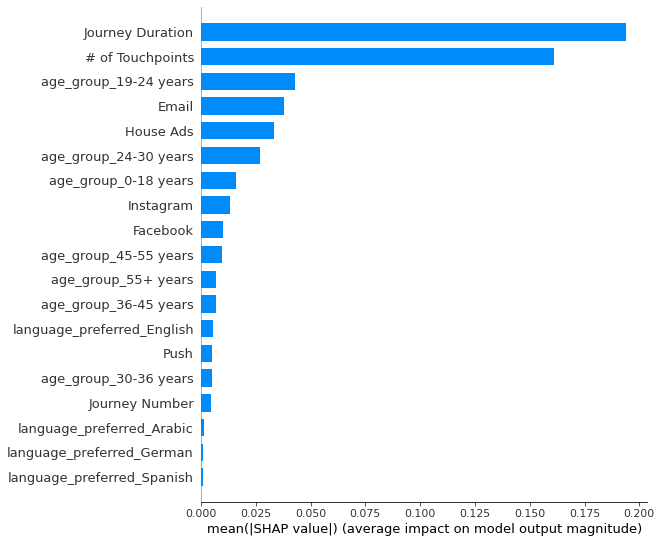

In [15]:
shap.summary_plot(shap_values[1], X_train, plot_type = 'bar', class_names=model1.classes_)

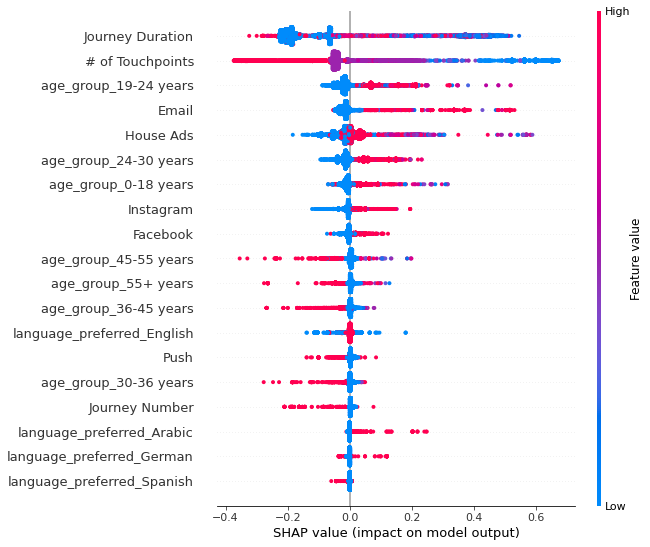

In [16]:
shap.summary_plot(shap_values[1], X_train, class_names=model1.classes_)

##### Logistic Regression

In [17]:
model2 = log_reg.best_estimator_.fit(X_train, y_train)
explainer = shap.Explainer(model2, X_train)
shap_values = explainer.shap_values(X_train)

In [18]:
y_pred = model2.predict(X_test)
report = classification_report(y_test, y_pred) 
print(report)

              precision    recall  f1-score   support

           0       0.93      0.65      0.77      1898
           1       0.27      0.72      0.39       340

    accuracy                           0.66      2238
   macro avg       0.60      0.68      0.58      2238
weighted avg       0.83      0.66      0.71      2238



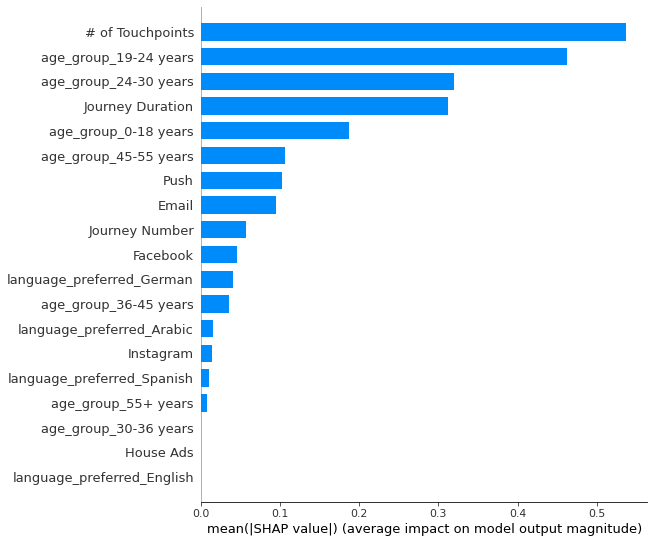

In [19]:
plt.figure(figsize=((10,8)))
shap.summary_plot(shap_values, X_train, plot_type="bar", class_names=model2.classes_, show=False)

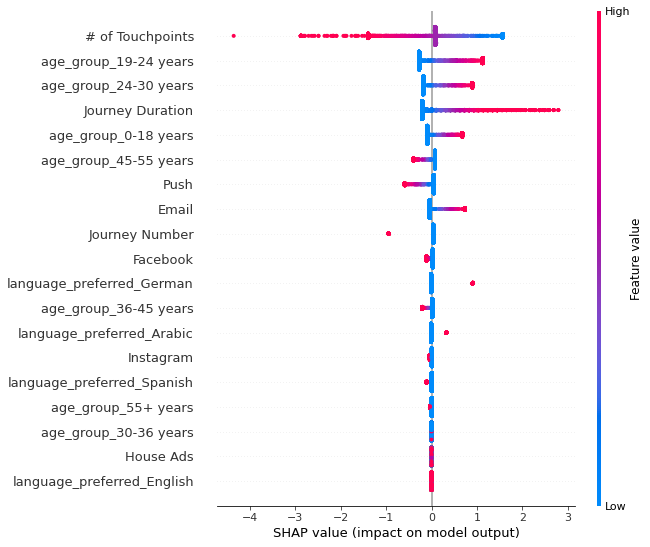

In [20]:
shap.summary_plot(shap_values, X_train, plot_type="dot", class_names=model2.classes_)

##### KNN

In [21]:
k_range = list(range(1, 50))
knn = KNeighborsClassifier()
param_grid = dict(n_neighbors=k_range)
grid = grid_search_wrapper(_model = knn, param_grid=param_grid) 


Best params for f1
{'n_neighbors': 5}

Confusion matrix of Random Forest optimized for f1 on the test data:
     pred_neg  pred_pos
neg      1598       300
pos       116       224


In [22]:
show_model_output(grid)

,mean_train_score,mean_out_of_sample_estimate_score,n_neighbors
4,0.839670,0.823151,5
2,0.846598,0.821770,3
0,0.856446,0.819915,1
6,0.833849,0.816602,7
5,0.835062,0.814739,6
8,0.829358,0.812533,9
7,0.829485,0.812310,8
3,0.833686,0.810738,4
10,0.825770,0.809523,11
9,0.824889,0.808391,10


In [23]:
model4 = grid_search_clf.best_estimator_.fit(X_train, y_train)
explainer = shap.Explainer(model4, X_train)
shap_values = explainer.shap_values(X_train)

 28%|======              | 5124/18084 [01:40<04:12]       

In [ ]:
y_pred = model4.predict(X_test)
report = classification_report(y_test, y_pred) 
print(report)

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1933
           1       0.74      0.62      0.67       305

    accuracy                           0.92      2238
   macro avg       0.84      0.79      0.81      2238
weighted avg       0.91      0.92      0.92      2238



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

##### KNN Plots

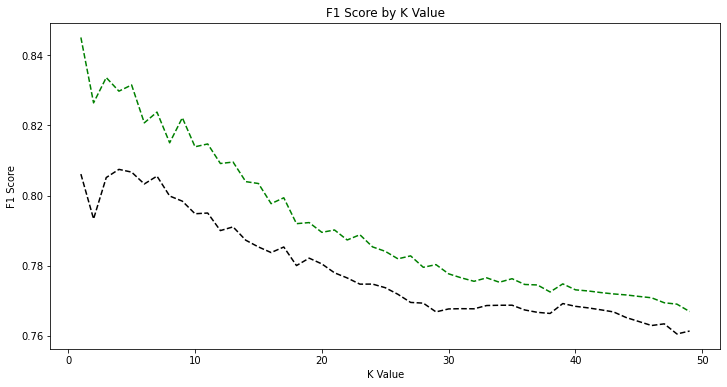

In [ ]:
cv = []
f_score = []

for i in range(1, 50):
    knn_cv = KNeighborsClassifier(n_neighbors=i)
    cv.append((cross_val_score(knn_cv, X_train, y_train, cv=10, scoring='f1')).mean())
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_train)
    # error.append(np.mean(pred_i != y_test))
    # accuracy.append(np.mean(pred_i == y_test))
    f_score.append(metrics.f1_score(y_train, list(pred_i)))



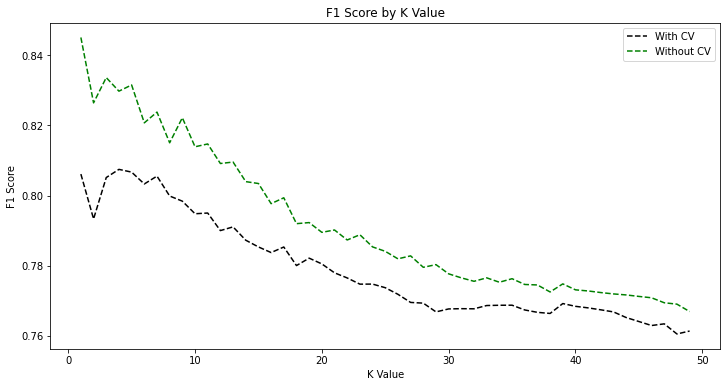

In [ ]:
plt.figure(figsize=(12, 6))
# plt.plot(range(k_min, k_max), f_score, color='black', linestyle='dashed', marker='x',
# markerfacecolor='green', markersize=10)
plt.plot(range(1, 50), cv, color='black', linestyle='dashed')
plt.plot(range(1, 50), f_score, color='green', linestyle='dashed')
# plt.plot(range(k_min, k_max), accuracy, color='green', linestyle='dashed')
plt.title('F1 Score by K Value')
plt.xlabel('K Value')
plt.ylabel('F1 Score')
plt.legend(['With CV','Without CV'])
plt.savefig('img.png', facecolor='w')